In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from util import csv_to_numpy


In [ ]:
# Load data
data_joint_vecs = np.load('input/000009.npy')

# Choose path to npy file
path = '/Users/joe/Documents/project/experiment/Convert-EMILYA/output/3Dpos/Nt1SW1_Actor7.npy'
emilya = np.load(path)
print(emilya.shape) 

(553, 22, 3)


In [ ]:
'''The joints are too close, so re-scale the distance between them'''
def scale_distances(data, scale_factor=0.8):
    scaled_data = np.copy(data)
    for frame in range(data.shape[0]):
        for i in range(1, data.shape[1]):
            # Calculate the distance between the current joint and the previous joint
            distance = np.linalg.norm(data[frame, i] - data[frame, i-1])
            
            # Scale the distance
            scaled_distance = distance * scale_factor
            
            # Adjust the joint position based on the scaled distance
            direction = (data[frame, i] - data[frame, i-1]) / distance # Get the direction from the previous joint to the current joint
            scaled_data[frame, i] = scaled_data[frame, i-1] + direction * scaled_distance # Update position
    return scaled_data

emilya = scale_distances(emilya, 6.5)


In [ ]:
'''Normalise the joint positions'''
def normalise(data):
    min_val = np.min(emilya)
    max_val = np.max(emilya)
    emilya_normalise = (emilya - min_val) / (max_val - min_val)
    emilya_normalise = emilya_normalise * 2 - 1

    return emilya_normalise

emilya = normalise(emilya)


In [ ]:
'''Visualise the joints of the skeleton from HumanML3D dataset'''
# Note ordering (0,1,2) represents the permutaton of the axes, so (0,3,2) displays x, z, y    
def display_skeleton(skeleton, ordering=(0,1,2), joint_num=-1, joints=[], frame=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set the axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Get x, y, z coordinates of each joint
    x = skeleton[0, :, ordering[0]] 
    y = skeleton[0, :, ordering[1]]  
    z = skeleton[0, :, ordering[2]] 

    if joint_num != -1:
        ax.scatter(x[joint_num], y[joint_num], z[joint_num], c='r', marker='o')

    ax.scatter(x, y, z)

    if len(joints) > 0:
        for joint in joints:
            ax.scatter(x[joint], y[joint], z[joint], c='r', marker='x', s=50)

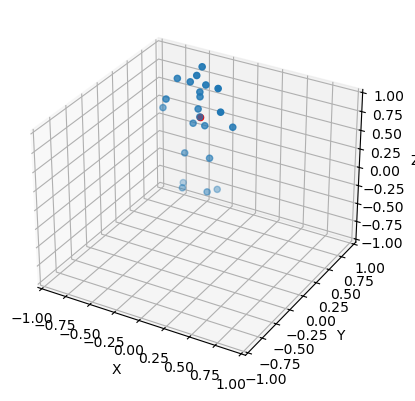

In [15]:
display_skeleton(data_joint_vecs, (0, 2, 1), 0)

In [ ]:
'''Display joints to be deleted'''
to_delete = [0, 5, 10, 19, 24, 27]
display_skeleton(emilya, ordering=(0, 1, 2), joint_num=0, joints=to_delete, frame=len(emilya)-1)

In [50]:
''''Remove joints to fit data'''
emilya = np.delete(emilya, to_delete, axis=1)
print(data_joint_vecs.shape, emilya.shape)
# Will have some retargeting error hopefully doesnt affect emotion - cannot avoid this 

(115, 22, 3) (283, 22, 3)


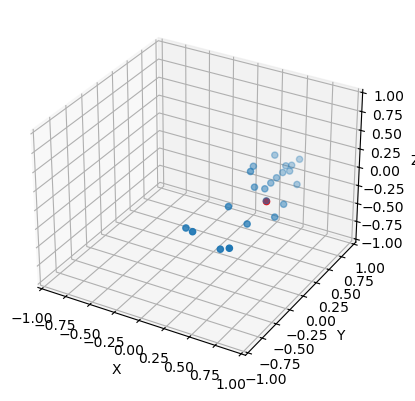

In [51]:
display_skeleton(emilya, (0, 1, 2), 0, [], len(emilya)-1)

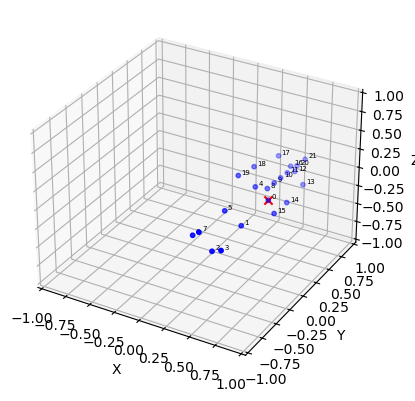

In [52]:
'''Number the skeleton joints for remapping'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Add 3D axis   

# Set the axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

frame = len(emilya) - 1
x = emilya[frame, :, 0] 
y = emilya[frame, :, 1]
z = emilya[frame, :, 2]

ax.scatter(x, y, z, c='b', marker='o', s=10) 


# Add joint numbers
for joint in range(len(x)):
    ax.text(x[joint] + 0.02, y[joint] + 0.02, z[joint] + 0.02, 
            f'{joint}',  # The joint number
            fontsize=5)  # Slight offset to avoid overlap

# It's quite hard to see which joint is which near the middle so we can highlight the joint here
joint_num = 0
ax.scatter(x[joint_num], y[joint_num], z[joint_num], c='r', marker='x', s=35)

In [ ]:
'''Remap the indicies to the HumanML3D skeleton'''
def remap():
    remap = {
            8: 0, 0: 1, 4: 2, 9: 3, 1: 4, 5: 5, 10: 6, 2: 7,
            6: 8, 11: 9, 3: 10, 7: 11, 20: 12, 12: 13, 16: 14,
            21: 15, 13: 16, 17: 17, 14: 18, 18: 19, 15: 20, 19: 21
        }

    remapped = np.zeros_like(emilya)

    for old, new in remap.items():
        remapped[:, new] = emilya[:, old]

    return remapped
emilya = remap()